In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [3]:
FIN_PATH = "/home/pedda/Documents/uni/FIN-Dataset"
scenes = os.listdir(FIN_PATH)
algorithms = ["draco","pccomp","tmc3","sparsepcgc"]
scenes, algorithms

(['hallway', 'auditorium', 'conferenceRoom', 'office'],
 ['draco', 'pccomp', 'tmc3', 'sparsepcgc'])

In [4]:
def gather_dfs(scene: str):
    root = os.path.join(FIN_PATH, scene)
    qual_data = dict()
    sim_data = dict()
    for subdir in os.listdir(root):
        if not os.path.isdir(os.path.join(root, subdir)) or subdir == "GT":
            continue
        metrics_path = os.path.join(root, subdir, "metrics", f"{subdir}-{scene}.csv")
        sim_path = os.path.join(root, subdir, "metrics", f"{subdir}-{scene}-sim.csv")
        metrics = pd.read_csv(metrics_path)
        sim = pd.read_csv(sim_path)
        sim["Cloud Size"] = metrics["num_points"]
        metrics["Symmetric Similarity"] = sim["Symmetric Similarity"]
        qual_data[subdir] = metrics
        sim_data[subdir] = sim
    return qual_data, sim_data

In [5]:
def gather_dfs_local():
    root = "metrics"
    qual_data = dict()
    sim_data = dict()
    for scene in scenes:
        print(scene)
        if scene not in qual_data:
            qual_data[scene] = dict()
            sim_data[scene] = dict()
        for algorithm in algorithms:
            print(algorithm)
            if algorithm == "sparsepcgc" and scene != "hallway":
                continue
            metrics_path = os.path.join(root, f"{algorithm}-{scene}-qual.csv")
            sim_path = os.path.join(root, f"{algorithm}-{scene}-sim.csv")
            metrics = pd.read_csv(metrics_path)
            if os.path.isfile(sim_path):
                sim = pd.read_csv(sim_path)
                sim["Cloud Size"] = metrics["num_points"]
                metrics["Symmetric Similarity"] = sim["Symmetric Similarity"]
                sim_data[scene][algorithm] = sim
            else:
                metrics["Symmetric Similarity"] = 0
            qual_data[scene][algorithm] = metrics
    return qual_data, sim_data

In [6]:
scene_qual_data, scene_sim_data = gather_dfs_local()
scene_qual_data

hallway
draco
pccomp
tmc3
sparsepcgc
auditorium
draco
pccomp
tmc3
sparsepcgc
conferenceRoom
draco
pccomp
tmc3
sparsepcgc
office
draco
pccomp
tmc3
sparsepcgc


{'hallway': {'draco':                 file        bpp  enc_file_size_bits  time_dec_ns  num_points  \
  0         T0-108.ply  32.148148                3472      3203166         108   
  1         T1-330.ply  14.206061                4688      6778865         330   
  2         T2-663.ply  11.028658                7312      6827248         663   
  3        T3-6474.ply   6.921223               44808      8584859        6474   
  4       T4-14646.ply   5.857162               85784     10131603       14646   
  ..               ...        ...                 ...          ...         ...   
  164  T164-892788.ply   3.053446             2726080    144703536      892788   
  165  T165-896679.ply   3.043114             2728696    129159396      896679   
  166  T166-904530.ply   3.045471             2754720     36834492      904530   
  167  T167-908724.ply   3.060115             2780800    143336002      908724   
  168  T168-911340.ply   3.064095             2792432     35387868      911340

In [7]:
algo_all = dict()
for scene in os.listdir(FIN_PATH):
    if scene == "hallway":
        continue
    for algo, df in scene_qual_data[scene].items():
        if not algo in algo_all:
            algo_all[algo] = df
        else:
            algo_all[algo] = pd.concat([algo_all[algo],df])
algo_all

{'draco':                  file  num_points  time_enc_ns  time_dec_ns  \
 0         T0-2550.ply        2550     13158899     10168446   
 1        T1-13563.ply       13563     16125063     10915847   
 2        T2-24081.ply       24081     23262837     12343140   
 3        T3-37614.ply       37614     33109321     17172038   
 4        T4-48780.ply       48780     39876603     18781307   
 ..                ...         ...          ...          ...   
 114  T114-1082778.ply     1082778    236499865     41504241   
 115  T115-1085112.ply     1085112    157627331     84940178   
 116  T116-1087941.ply     1087941    264408056     41912606   
 117  T117-1091295.ply     1091295    133094042     75429698   
 118  T118-1092495.ply     1092495    235366703    151065247   
 
      enc_file_size_bits       bpp  Symmetric Similarity  
 0                 19040  7.466667              0.987978  
 1                 85232  6.284155              0.981712  
 2                142384  5.912711          

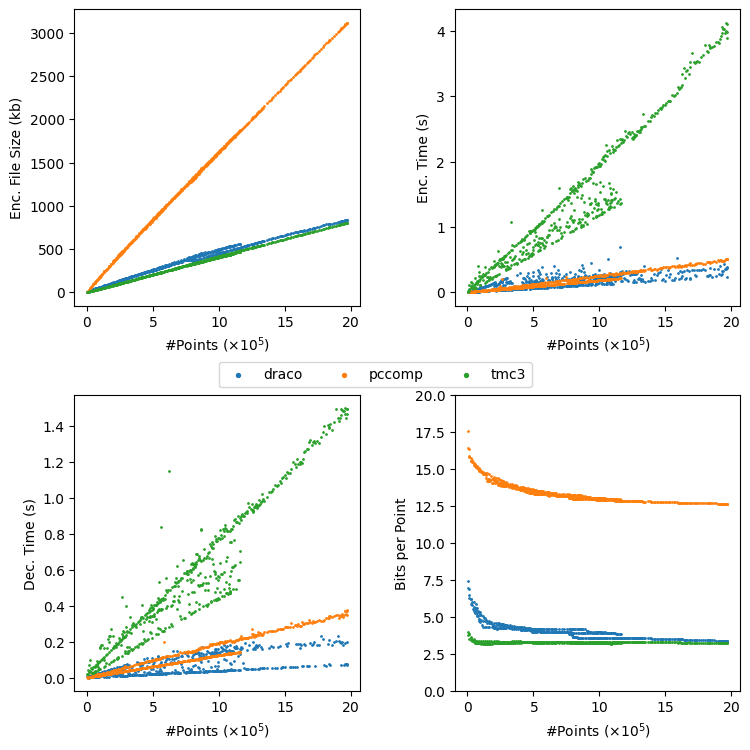

In [8]:
fig, axs = plt.subplots(2,2, figsize=(8, 8))
ls = []
import matplotlib.ticker as mtick
algorithms = []
for algorithm, df in algo_all.items():
    algorithms.append(algorithm)
    bpps = df["bpp"]
    enc_size = df["enc_file_size_bits"]/8000
    time_enc = df["time_enc_ns"]/10**9
    time_dec = df["time_dec_ns"]/10**9
    points = df["num_points"] / 10**5
    l = axs[0, 0].scatter(points, enc_size, s=1)
    ls.append(l)
    axs[0, 0].set_ylabel("Enc. File Size (kb)")
    axs[0, 1].scatter(points, time_enc, s=1)
    axs[0, 1].set_ylabel("Enc. Time (s)")
    axs[1, 0].scatter(points, time_dec, s=1)
    axs[1, 0].set_ylabel("Dec. Time (s)")
    axs[1, 1].scatter(points, bpps, s=1, label=algorithm)
    axs[1, 1].set_ylabel("Bits per Point")
    axs[1, 1].set_ylim(0, 20)
for ax in axs.flat:
    ax.set_xlabel("#Points ($\\times 10^5$)")
    ax.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
lgnd = fig.legend(ls, algorithms, loc="center", ncols=(3))
for handle in lgnd.legend_handles:
    handle.set_sizes([8.0])
fig.tight_layout(pad=2.5)
plt.show()

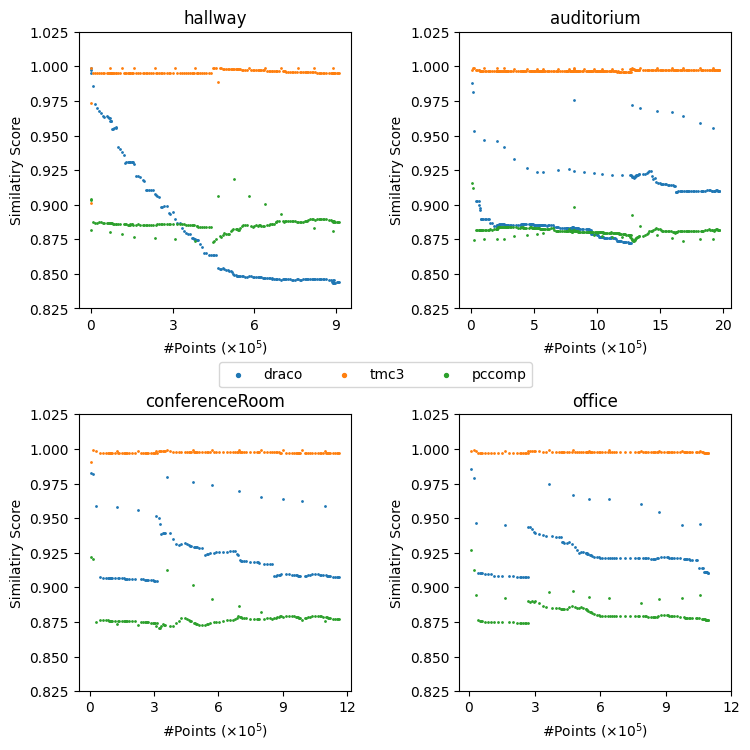

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(8,8))
ls = []

for i, scene in enumerate(scenes):
    for algo, df in scene_sim_data[scene].items():
        if algo =="sparsepcgc":
            continue
        similarity = df["Symmetric Similarity"]    
        cloud_size = df["Cloud Size"] / 10**5
        l = axs.flat[i].scatter(cloud_size, similarity, s=1)
        ls.append(l)
        if scene == "hallway":
            axs.flat[i].set_xticks([0, 3, 6,  9])
        if scene == "auditorium":
            axs.flat[i].set_xticks([0, 5, 10, 15, 20])
        if scene == "office":
            axs.flat[i].set_xticks([0, 3, 6,  9, 12])
        if scene == "conferenceRoom":
            axs.flat[i].set_xticks([0, 3, 6, 9, 12])
        axs.flat[i].set_ylim([0.825, 1.025])
        axs.flat[i].set_xlabel("#Points ($\\times 10^5$)")
        axs.flat[i].xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
        axs.flat[i].set_title(scene)
        axs.flat[i].set_ylabel("Similatiry Score")
lgnd = fig.legend(ls, ["draco","tmc3", "pccomp"], loc="center", ncols=(3))
for handle in lgnd.legend_handles:
    handle.set_sizes([8.0])
fig.tight_layout(pad=2.5)

plt.show()

In [11]:
for algo, df in algo_all.items():
    similarity = df["Symmetric Similarity"]    
    bpp = df["bpp"]    
    avg_sim = np.average(similarity)
    avg_bpp = np.average(bpp)
    avg_enc = np.average(np.divide(df["time_enc_ns"], df["num_points"]))
    avg_dec = np.average(np.divide(df["time_dec_ns"], df["num_points"]))
    print(algo)
    print(f"\tAvg. similarity score: {avg_sim}")
    print(f"\tAvg. bpp:              {avg_bpp}")
    print(f"\tAvg. enc:              {avg_enc} ns")
    print(f"\tAvg. dec:              {avg_dec} ns")

draco
	Avg. similarity score: 0.9102983111751499
	Avg. bpp:              4.073897942718478
	Avg. enc:              299.75608512188114 ns
	Avg. dec:              121.2680155469369 ns
pccomp
	Avg. similarity score: 0.9973608799902891
	Avg. bpp:              13.42561457684945
	Avg. enc:              234.0300199487563 ns
	Avg. dec:              166.52065425248597 ns
tmc3
	Avg. similarity score: 0.8803690207661795
	Avg. bpp:              3.2957759934383972
	Avg. enc:              1788.0787331884592 ns
	Avg. dec:              779.7512057547013 ns


In [ ]:
per_scene = dict()
for qual in os.listdir("metrics"):
    if "qual" not in qual:
        continue
    algo, scene, _ = qual.split("-")
    if scene not in per_scene:
        per_scene[scene] = dict()
    per_scene[scene][algo] = pd.read_csv(os.path.join("metrics", qual))
    

In [ ]:
hallway_all = dict()
for algo, df in scene_qual_data["hallway"].items():
    if not algo in hallway_all:
        hallway_all[algo] = df
    else:
        hallway_all[algo] = pd.concat([hallway_all[algo],df])
hallway_all

{'draco':                 file        bpp  enc_file_size_bits  time_dec_ns  num_points  \
 0         T0-108.ply  32.148148                3472      3203166         108   
 1         T1-330.ply  14.206061                4688      6778865         330   
 2         T2-663.ply  11.028658                7312      6827248         663   
 3        T3-6474.ply   6.921223               44808      8584859        6474   
 4       T4-14646.ply   5.857162               85784     10131603       14646   
 ..               ...        ...                 ...          ...         ...   
 164  T164-892788.ply   3.053446             2726080    144703536      892788   
 165  T165-896679.ply   3.043114             2728696    129159396      896679   
 166  T166-904530.ply   3.045471             2754720     36834492      904530   
 167  T167-908724.ply   3.060115             2780800    143336002      908724   
 168  T168-911340.ply   3.064095             2792432     35387868      911340   
 
      time_enc_ns

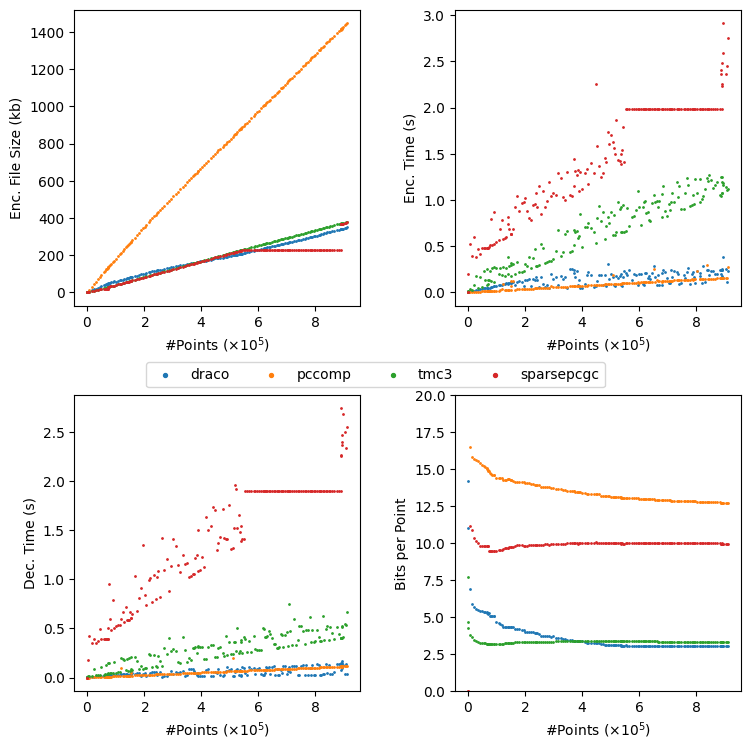

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(8,8))
ls = []
import matplotlib.ticker as mtick
algorithms = []
for algorithm, df in hallway_all.items():
    algorithms.append(algorithm)
    bpps = df["bpp"]
    enc_size = df["enc_file_size_bits"]/8000
    time_enc = df["time_enc_ns"]/10**9
    time_dec = df["time_dec_ns"]/10**9
    points = df["num_points"] / 10**5
    l = axs[0, 0].scatter(points, enc_size, s=1)
    ls.append(l)
    axs[0, 0].set_ylabel("Enc. File Size (kb)")
    axs[0, 1].scatter(points, time_enc, s=1)
    axs[0, 1].set_ylabel("Enc. Time (s)")
    axs[1, 0].scatter(points, time_dec, s=1)
    axs[1, 0].set_ylabel("Dec. Time (s)")
    axs[1, 1].scatter(points, bpps, s=1, label=algorithm)
    axs[1, 1].set_ylabel("Bits per Point")
    axs[1, 1].set_ylim(0, 20)
for ax in axs.flat:
    ax.set_xlabel("#Points ($\\times 10^5$)")
    ax.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
lgnd = fig.legend(ls, algorithms, loc="center", ncols=(4))
for handle in lgnd.legend_handles:
    handle.set_sizes([8.0])
fig.tight_layout(pad=2.5)
plt.show()